In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda, multiply, concatenate, add
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras import optimizers
from keras.datasets import mnist
import pandas as pd
import tensorflow as tf

/Users/semihakbayrak/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using TensorFlow backend.


In [2]:
# Initialize Keras with Tensorflow session
sess = tf.Session()
K.set_session(sess)

In [3]:
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('u.data', sep='\t', header=None, names=rnames)
ratings

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


# Gaussian Link Function

In [4]:
M = max(ratings['movie_id']) #Number of rows
N = max(ratings['user_id']) #Number of columns

R = np.nan*np.ones((M,N)) #datamatrix

for k in range(len(ratings)):
    i = ratings['movie_id'][k] - 1
    j = ratings['user_id'][k] - 1
    #transform original ratings to binary ratings
    r = ratings['rating'][k]
    R[i,j] = r

print R

[[  5.   4.  nan ...,   5.  nan  nan]
 [  3.  nan  nan ...,  nan  nan   5.]
 [  4.  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]]


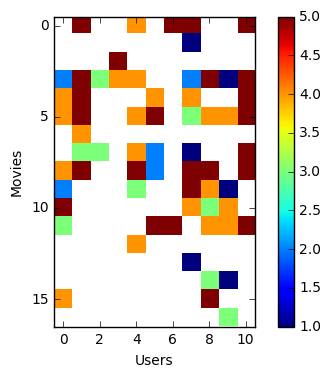

In [5]:
Data = R[3:20,5:16] #Sample from original data matrix

plt.imshow(Data, interpolation='nearest',vmax=5,vmin=1)
plt.colorbar()
plt.set_cmap('jet')
plt.xlabel('Users')
plt.ylabel('Movies')
plt.show()

In [6]:
#batch_size = len(ratings)
batch_size = 50
movie_in_dim = N
user_in_dim = M
latent_dim = 20
intermediate_dim = 125
semi_final_dim = 40
final_dim = 1
nb_epoch = 10
epsilon_std = 1.0

In [7]:
#encoder
x_m = Input(batch_shape=(batch_size, movie_in_dim))
x_u = Input(batch_shape=(batch_size, user_in_dim))
z_mean_m = Dense(latent_dim, activation='tanh')(x_m)
z_log_var_m = Dense(latent_dim, activation='tanh')(x_m)
z_mean_u = Dense(latent_dim, activation='tanh')(x_u)
z_log_var_u = Dense(latent_dim, activation='tanh')(x_u)

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z_m = Lambda(sampling, output_shape=(latent_dim,))([z_mean_m, z_log_var_m])
z_u = Lambda(sampling, output_shape=(latent_dim,))([z_mean_u, z_log_var_u])

In [9]:
#decoder
def inner_mult(args):
    z_m,z_u = args
    return tf.multiply(z_m,z_u)
    
z = Lambda(inner_mult,output_shape=(latent_dim,))([z_m, z_u])
print z

decoder_h = Dense(semi_final_dim, activation='tanh')
decoder_mean = Dense(final_dim)
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)
print x_decoded_mean

Tensor("lambda_3/Mul:0", shape=(50, 20), dtype=float32)
Tensor("dense_6/BiasAdd:0", shape=(50, 1), dtype=float32)


In [10]:
#loss
def vae_loss(y, x_decoded_mean):
    xent_loss = objectives.mean_squared_error(y, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var_m - K.square(z_mean_m) - K.exp(z_log_var_m), axis=-1) - 0.5 * K.mean(1 + z_log_var_u - K.square(z_mean_u) - K.exp(z_log_var_u), axis=-1)
    return xent_loss + kl_loss

vae = Model([x_m,x_u], x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [11]:
X = np.zeros((M,N)) #datamatrix

for k in range(len(ratings)):
    i = ratings['movie_id'][k] - 1
    j = ratings['user_id'][k] - 1
    #transform original ratings to binary ratings
    r = ratings['rating'][k]
    X[i,j] = r

print X

[[ 5.  4.  0. ...,  5.  0.  0.]
 [ 3.  0.  0. ...,  0.  0.  5.]
 [ 4.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [12]:
X_m = np.zeros((len(ratings),N)) #datamatrix
X_u = np.zeros((len(ratings),M)) #datamatrix
y = np.zeros((len(ratings),1))

for k in range(len(ratings)):
    i = ratings['movie_id'][k] - 1
    j = ratings['user_id'][k] - 1
    #transform original ratings to binary ratings
    r = ratings['rating'][k]
    #X[i,j] = r
    X_m[k] = X[i,:]
    X_u[k] = X[:,j]
    y[k] = r

print X_m
print X_u
print y

[[ 5.  5.  0. ...,  0.  0.  0.]
 [ 0.  5.  2. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 2.  0.  0. ...,  0.  0.  0.]
 [ 4.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  2.  0. ...,  0.  0.  0.]
 ..., 
 [ 5.  4.  3. ...,  0.  0.  0.]
 [ 3.  3.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 3.]
 [ 3.]
 [ 1.]
 ..., 
 [ 1.]
 [ 2.]
 [ 3.]]


In [13]:
vae.fit([X_m,X_u], y,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=None,verbose=2)

/Users/semihakbayrak/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/10
15s - loss: 2.3323
Epoch 2/10
11s - loss: 1.8497
Epoch 3/10
11s - loss: 1.6542
Epoch 4/10
11s - loss: 1.5775
Epoch 5/10
10s - loss: 1.5352
Epoch 6/10
10s - loss: 1.5136
Epoch 7/10
10s - loss: 1.5025
Epoch 8/10
10s - loss: 1.4889
Epoch 9/10
10s - loss: 1.4802
Epoch 10/10
10s - loss: 1.4744


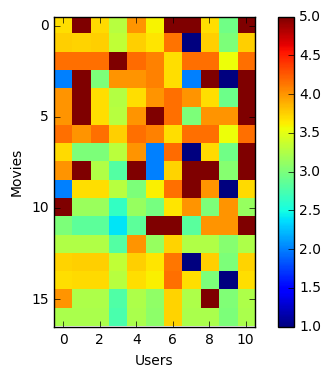

In [14]:
encoder_u = Model(x_u, z_mean_u)
encoder_m = Model(x_m, z_mean_m)

x_test_encoded_u = encoder_u.predict(X_u, batch_size=batch_size)
x_test_encoded_m = encoder_m.predict(X_m, batch_size=batch_size)
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

Data_show = R[3:20,5:16]

for i in range(17):
    for j in range(11):
        if np.isnan(Data_show[i,j]):
            x_decoded = np.multiply(x_test_encoded_m[i+3],x_test_encoded_u[j+5])
            x_decoded = x_decoded.reshape(1,latent_dim)
            Data_show[i,j] = generator.predict(x_decoded)

plt.imshow(R[3:20,5:16], interpolation='nearest',vmax=5,vmin=1)
plt.colorbar()
plt.set_cmap('jet')
plt.xlabel('Users')
plt.ylabel('Movies')
plt.show()

# Poisson Link Function

In [15]:
M = max(ratings['movie_id']) #Number of rows
N = max(ratings['user_id']) #Number of columns

R = np.nan*np.ones((M,N)) #datamatrix

for k in range(len(ratings)):
    i = ratings['movie_id'][k] - 1
    j = ratings['user_id'][k] - 1
    #transform original ratings to binary ratings
    r = ratings['rating'][k]
    R[i,j] = r

print R

[[  5.   4.  nan ...,   5.  nan  nan]
 [  3.  nan  nan ...,  nan  nan   5.]
 [  4.  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]]


In [16]:
#batch_size = len(ratings)
batch_size = 50
movie_in_dim = N
user_in_dim = M
latent_dim = 20
intermediate_dim = 125
semi_final_dim = 40
final_dim = 1
nb_epoch = 10
epsilon_std = 1.0

In [17]:
#encoder
x_m = Input(batch_shape=(batch_size, movie_in_dim))
x_u = Input(batch_shape=(batch_size, user_in_dim))
z_mean_m = Dense(latent_dim, activation='tanh')(x_m)
z_log_var_m = Dense(latent_dim, activation='tanh')(x_m)
z_mean_u = Dense(latent_dim, activation='tanh')(x_u)
z_log_var_u = Dense(latent_dim, activation='tanh')(x_u)

In [18]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z_m = Lambda(sampling, output_shape=(latent_dim,))([z_mean_m, z_log_var_m])
z_u = Lambda(sampling, output_shape=(latent_dim,))([z_mean_u, z_log_var_u])

In [19]:
#decoder
def inner_mult(args):
    z_m,z_u = args
    return tf.multiply(z_m,z_u)
    
z = Lambda(inner_mult,output_shape=(latent_dim,))([z_m, z_u])
print z

decoder_h = Dense(semi_final_dim, activation='tanh')
decoder_mean = Dense(final_dim, activation=tf.exp)
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)
print x_decoded_mean

Tensor("lambda_6/Mul:0", shape=(50, 20), dtype=float32)
Tensor("dense_12/Exp:0", shape=(50, 1), dtype=float32)


In [20]:
#loss
def vae_loss(y, x_decoded_mean):
    xent_loss = objectives.poisson(y, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var_m - K.square(z_mean_m) - K.exp(z_log_var_m), axis=-1) - 0.5 * K.mean(1 + z_log_var_u - K.square(z_mean_u) - K.exp(z_log_var_u), axis=-1)
    return xent_loss  + 0*kl_loss
    #varyans = 50
    #kl_loss = - 0.5 * K.mean(1 + z_log_var_m - np.log(varyans) - (K.square(z_mean_m))*(1.0/varyans) - K.exp(z_log_var_m)*(1.0/varyans), axis=-1) - 0.5 * K.mean(1 + z_log_var_u - np.log(varyans) - (K.square(z_mean_u))*(1.0/varyans) - K.exp(z_log_var_u)*(1.0/varyans), axis=-1)
    #return xent_loss  + kl_loss

vae = Model([x_m,x_u], x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [21]:
X = np.zeros((M,N)) #datamatrix

for k in range(len(ratings)):
    i = ratings['movie_id'][k] - 1
    j = ratings['user_id'][k] - 1
    #transform original ratings to binary ratings
    r = ratings['rating'][k]
    X[i,j] = r

In [22]:
X_m = np.zeros((len(ratings),N)) #datamatrix
X_u = np.zeros((len(ratings),M)) #datamatrix
y = np.zeros((len(ratings),1))

for k in range(len(ratings)):
    i = ratings['movie_id'][k] - 1
    j = ratings['user_id'][k] - 1
    #transform original ratings to binary ratings
    r = ratings['rating'][k]
    #X[i,j] = r
    X_m[k] = X[i,:]
    X_u[k] = X[:,j]
    y[k] = r

In [23]:
vae.fit([X_m,X_u], y,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=None,verbose=2)

/Users/semihakbayrak/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/10
16s - loss: -9.0005e-01
Epoch 2/10
15s - loss: -9.5267e-01
Epoch 3/10
13s - loss: -9.6010e-01
Epoch 4/10
13s - loss: -9.6477e-01
Epoch 5/10
14s - loss: -9.6804e-01
Epoch 6/10
12s - loss: -9.7009e-01
Epoch 7/10
10s - loss: -9.7177e-01
Epoch 8/10
11s - loss: -9.7267e-01
Epoch 9/10
10s - loss: -9.7383e-01
Epoch 10/10
11s - loss: -9.7526e-01


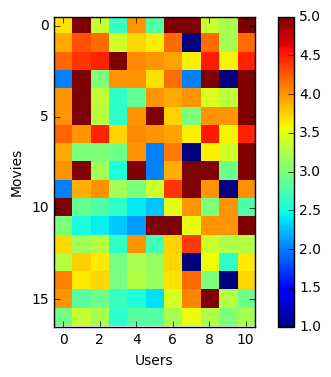

In [24]:
encoder_u = Model(x_u, z_mean_u)
encoder_m = Model(x_m, z_mean_m)

x_test_encoded_u = encoder_u.predict(X_u, batch_size=batch_size)
x_test_encoded_m = encoder_m.predict(X_m, batch_size=batch_size)
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

Data_show = R[3:20,5:16] #Sample from original data matrix

for i in range(17):
    for j in range(11):
        if np.isnan(Data_show[i,j]):
            x_decoded = np.multiply(x_test_encoded_m[i+3],x_test_encoded_u[j+5])
            x_decoded = x_decoded.reshape(1,latent_dim)
            Data_show[i,j] = generator.predict(x_decoded)

plt.imshow(R[3:20,5:16], interpolation='nearest',vmax=5,vmin=1)
plt.colorbar()
plt.set_cmap('jet')
plt.xlabel('Users')
plt.ylabel('Movies')
plt.show()

# Bernoulli Link Function

In [25]:
M = max(ratings['movie_id']) #Number of rows
N = max(ratings['user_id']) #Number of columns

R = np.nan*np.ones((M,N)) #datamatrix

for k in range(len(ratings)):
    i = ratings['movie_id'][k] - 1
    j = ratings['user_id'][k] - 1
    #transform original ratings to binary ratings
    r = ratings['rating'][k]
    if r > 3:
        R[i,j] = 1
    else:
        R[i,j] = 0

print R

[[  1.   1.  nan ...,   1.  nan  nan]
 [  0.  nan  nan ...,  nan  nan   1.]
 [  1.  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]]


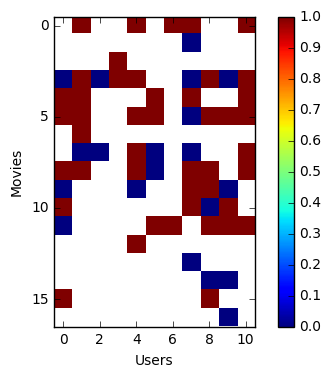

In [26]:
Data = R[3:20,5:16] #Sample from original data matrix

plt.imshow(Data, interpolation='nearest',vmax=1,vmin=0)
plt.colorbar()
plt.set_cmap('jet')
plt.xlabel('Users')
plt.ylabel('Movies')
plt.show()

In [27]:
#batch_size = len(ratings)
batch_size = 50
movie_in_dim = N
user_in_dim = M
latent_dim = 20
intermediate_dim = 125
semi_final_dim = 40
final_dim = 1
nb_epoch = 10
epsilon_std = 1.0

In [28]:
#encoder
x_m = Input(batch_shape=(batch_size, movie_in_dim))
x_u = Input(batch_shape=(batch_size, user_in_dim))
z_mean_m = Dense(latent_dim, activation='tanh')(x_m)
z_log_var_m = Dense(latent_dim, activation='tanh')(x_m)
z_mean_u = Dense(latent_dim, activation='tanh')(x_u)
z_log_var_u = Dense(latent_dim, activation='tanh')(x_u)

In [29]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z_m = Lambda(sampling, output_shape=(latent_dim,))([z_mean_m, z_log_var_m])
z_u = Lambda(sampling, output_shape=(latent_dim,))([z_mean_u, z_log_var_u])

In [30]:
#decoder
def inner_mult(args):
    z_m,z_u = args
    return tf.multiply(z_m,z_u)
    
z = Lambda(inner_mult,output_shape=(latent_dim,))([z_m, z_u])
print z

decoder_h = Dense(semi_final_dim, activation='tanh')
decoder_mean = Dense(final_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)
print x_decoded_mean

Tensor("lambda_9/Mul:0", shape=(50, 20), dtype=float32)
Tensor("dense_18/Sigmoid:0", shape=(50, 1), dtype=float32)


In [31]:
#loss
def vae_loss(y, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(y, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var_m - K.square(z_mean_m) - K.exp(z_log_var_m), axis=-1) - 0.5 * K.mean(1 + z_log_var_u - K.square(z_mean_u) - K.exp(z_log_var_u), axis=-1)
    return xent_loss + 0.1*kl_loss

vae = Model([x_m,x_u], x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [32]:
X = np.zeros((M,N)) #datamatrix

for k in range(len(ratings)):
    i = ratings['movie_id'][k] - 1
    j = ratings['user_id'][k] - 1
    #transform original ratings to binary ratings
    r = ratings['rating'][k]
    if r > 3:
        X[i,j] = 1
    else:
        X[i,j] = 0

print X

[[ 1.  1.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [33]:
X_m = np.zeros((len(ratings),N)) #datamatrix
X_u = np.zeros((len(ratings),M)) #datamatrix
y = np.zeros((len(ratings),1))

for k in range(len(ratings)):
    i = ratings['movie_id'][k] - 1
    j = ratings['user_id'][k] - 1
    #transform original ratings to binary ratings
    r = ratings['rating'][k]
    #X[i,j] = r
    X_m[k] = X[i,:]
    X_u[k] = X[:,j]
    if r > 3:
        y[k] = 1
    else:
        y[k] = 0

print X_m
print X_u
print y

[[ 1.  1.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 1.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 ..., 
 [ 0.]
 [ 0.]
 [ 0.]]


In [34]:
vae.fit([X_m,X_u], y,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=None,verbose=2)

/Users/semihakbayrak/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/10
15s - loss: 0.6800
Epoch 2/10
11s - loss: 0.6570
Epoch 3/10
11s - loss: 0.6458
Epoch 4/10
10s - loss: 0.6383
Epoch 5/10
12s - loss: 0.6351
Epoch 6/10
12s - loss: 0.6318
Epoch 7/10
12s - loss: 0.6285
Epoch 8/10
10s - loss: 0.6282
Epoch 9/10
10s - loss: 0.6249
Epoch 10/10
10s - loss: 0.6267


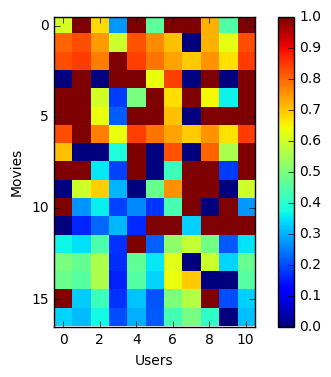

In [35]:
encoder_u = Model(x_u, z_mean_u)
encoder_m = Model(x_m, z_mean_m)

x_test_encoded_u = encoder_u.predict(X_u, batch_size=batch_size)
x_test_encoded_m = encoder_m.predict(X_m, batch_size=batch_size)
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

Data_show = R[3:20,5:16] 

for i in range(17):
    for j in range(11):
        if np.isnan(Data_show[i,j]):
            x_decoded = np.multiply(x_test_encoded_m[i+3],x_test_encoded_u[j+5])
            x_decoded = x_decoded.reshape(1,latent_dim)
            Data_show[i,j] = generator.predict(x_decoded)

plt.imshow(R[3:20,5:16], interpolation='nearest',vmax=1,vmin=0)
plt.colorbar()
plt.set_cmap('jet')
plt.xlabel('Users')
plt.ylabel('Movies')
plt.show()